# Using a Modflow DRN model as a stressmodel in Pastas

In [1]:
import os

import flopy
import pandas as pd
import pastas as ps

import pastas_plugins.modflow as ppmf

from pastas.timer import SolveTimer

bindir = "bin"
mf6_exe = os.path.join(bindir, "mf6.exe")
if not os.path.isfile(mf6_exe):
    if not os.path.isdir(bindir):
        os.makedirs(bindir)
    flopy.utils.get_modflow("bin", repo="modflow6")

fetched release '6.5.0' info from MODFLOW-USGS/modflow6
using previous download 'C:\Users\Ruben\Downloads\modflow6-6.5.0-win64.zip' (use 'force=True' to re-download)
extracting 4 files to 'C:\Users\Ruben\Documents\GitHub\pastas-plugins\docs\examples\bin'
libmf6.dll mf5to6.exe mf6.exe    zbud6.exe
updated flopy metadata file: 'C:\Users\Ruben\AppData\Local\flopy\get_modflow.json'


In [2]:
df = pd.read_csv("data/aftopping.csv", index_col=0, parse_dates=True)
head = df["B28H1808_2"].dropna()
prec = df["Precipitation"]
evap = df["Evaporation"]

Fit report B28H1808_2             Fit Statistics
nfev    16                     EVP         96.88
nobs    1261                   R2           0.97
noise   False                  RMSE         0.05
tmin    2012-06-07 00:00:00    AICc     -7360.14
tmax    2017-02-01 00:00:00    BIC      -7324.25
freq    D                      Obj          1.82
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (7 optimized)
           optimal     initial  vary
exp_A0  661.881263  258.226873  True
exp_a0  117.485675   10.000000  True
exp_d0   19.664685   19.675000  True
exp_A1  368.738780  258.226873  True
exp_a1  138.281724   10.000000  True
exp_d1   20.000696   20.032500  True
exp_f    -1.060276   -1.000000  True


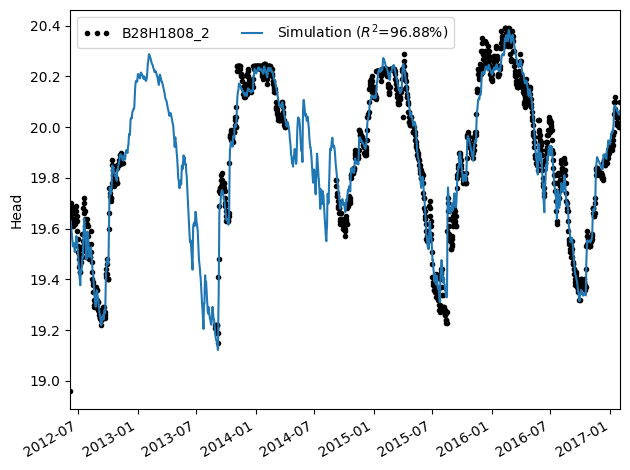

In [3]:
mlexp = ps.Model(head, constant=False)
mlexp.add_stressmodel(
    ps.TarsoModel(prec=prec, evap=evap, rfunc=ps.Exponential(), name="exp", oseries=head)
)
mlexp.solve()
mlexp.plot();

Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.


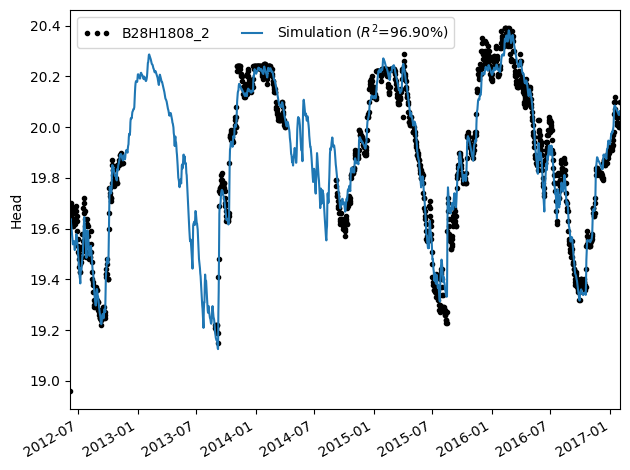

In [4]:
mldmf = ps.Model(head, constant=False)
expmf = ppmf.ModflowTarso(exe_name=mf6_exe, sim_ws="mf_files/drn_gw", head=head, silent=True)
expsm = ppmf.ModflowModel(prec=prec, evap=evap, modflow=expmf, name="expsm")
mldmf.add_stressmodel(expsm)
a0 = mlexp.parameters.at["exp_a0", "optimal"]
A0 = mlexp.parameters.at["exp_A0", "optimal"]
s = a0 / A0
d0 = mlexp.parameters.at["exp_d0", "optimal"]
d1 = mlexp.parameters.at["exp_d1", "optimal"]
A1 = mlexp.parameters.at["exp_A1", "optimal"]
f = mlexp.parameters.at["exp_f", "optimal"]
mldmf.set_parameter(f"{expsm.name}_d", initial=d0)
mldmf.set_parameter(f"{expsm.name}_s", initial=s)
mldmf.set_parameter(f"{expsm.name}_c", initial=A0)
mldmf.set_parameter(f"{expsm.name}_h_drn", initial=d1 - d0)
mldmf.set_parameter(f"{expsm.name}_c_drn", initial=A1)
mldmf.set_parameter(f"{expsm.name}_f", initial=f)
if isinstance(expmf, ppmf.ModflowTarso):
    a1 = mlexp.parameters.at["exp_a1", "optimal"]
    s_drn = a1 / A1
    mldmf.set_parameter(f"{expsm.name}_s_drn", initial=s_drn)
mldmf.initialize()
ax = mldmf.plot()

In [5]:
mldmf.parameters

,initial,pmin,pmax,vary,name,dist,stderr,optimal
expsm_d,19.664685,18.960,2.039000e+01,True,expsm,uniform,NaN,NaN
expsm_c,661.881263,10.000,1.000000e+08,True,expsm,uniform,NaN,NaN
expsm_s,0.177503,0.001,5.000000e-01,True,expsm,uniform,NaN,NaN
expsm_f,-1.060276,-2.000,0.000000e+00,True,expsm,uniform,NaN,NaN
expsm_h_drn,0.336012,0.000,1.000000e+01,True,expsm,uniform,NaN,NaN
expsm_c_drn,368.738780,10.000,1.000000e+08,True,expsm,uniform,NaN,NaN
expsm_s_drn,0.375013,0.300,1.000000e+00,True,expsm,uniform,NaN,NaN


Model is not optimized yet, initial parameters are used.


<Axes: >

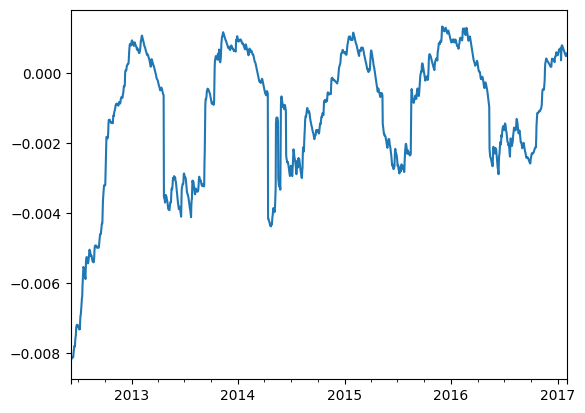

In [6]:
# plot the difference between both models
h1 = mlexp.simulate()
h2 = mldmf.simulate()
(h1-h2).dropna().plot()